In [1]:
import numpy as np
import pandas as pd
import math
import numpy.random as rand
import scipy
from scipy.stats import binom as binomial
from scipy.stats import beta as betafunction
from scipy.stats import norm
from scipy.stats import gamma
import matplotlib.pyplot as plt
from IPython.display import display
import sys
import pickle
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels

import seaborn
seaborn.set_style('ticks')
seaborn.set_color_codes()
import corner

#Mapping
import matplotlib.cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize


### Simulated Data ###
Data with known force of infection and vaccination hazard. Used to understand the biases we may have in our results. We looked at fitting to vaccination, serology, and case data as well as vaccination/case only.

In [33]:
#Load in chains run using all three datasets from fake data:
samples = []
i = 0
burnin = 1000
for line in open('chains/fakedata/veff0.5/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samples50 = np.array(samples)
samples50 = samples50.astype(float)

samples = []
i = 0
for line in open('chains/fakedata/veff0.6/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samples60 = np.array(samples)
samples60 = samples60.astype(float)

samples = []
i = 0
for line in open('chains/fakedata/veff0.7/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samples70 = np.array(samples)
samples70 = samples70.astype(float)

samples = []
i = 0
for line in open('chains/fakedata/veff0.8/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samples80 = np.array(samples)
samples80 = samples80.astype(float)

samples = []
i = 0
for line in open('chains/fakedata/veff0.9/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samples90 = np.array(samples)
samples90 = samples90.astype(float)

samples = []
i = 0
for line in open('chains/fakedata/veff1.0/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samples100 = np.array(samples)
samples100 = samples100.astype(float)

In [34]:
#Load in chains run using only vaccination and case data:

samples = []
i = 0
for line in open('chains/fakedata/vaxcase/veff0.6/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samplesvc60 = np.array(samples)
samplesvc60 = samplesvc60.astype(float)

samples = []
i = 0
for line in open('chains/fakedata/vaxcase/veff0.7/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samplesvc70 = np.array(samples)
samplesvc70 = samplesvc70.astype(float)

samples = []
i = 0
for line in open('chains/fakedata/vaxcase/veff0.8/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samplesvc80 = np.array(samples)
samplesvc80 = samplesvc80.astype(float)

samples = []
i = 0
for line in open('chains/fakedata/vaxcase/veff0.9/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samplesvc90 = np.array(samples)
samplesvc90 = samplesvc90.astype(float)

In [131]:
#Read in the simulated data itself: (this needed to be manipulated a bit. See FakeData.ipynb)
Data_pd = pd.read_csv("../Data/FakeData50_veff0.6.csv",header=None)
Data60 = Data_pd.as_matrix()
vo60 = Data60[:,0].copy()
vt60 = Data60[:,1].copy()
so60 = Data60[:,2].copy()
st60 = Data60[:,3].copy()
cobs60 = Data60[:,4].copy()

total_cases60 = np.sum(cobs60[:])

vobs60 = vo60.copy()
vtry60 = vt60.copy()
sobs60 = so60.copy()
stry60 = st60.copy()

#Getting more data for the plot - seroprevalence at all ages.

SData_pd = pd.read_csv("../Data/FakeSero_veff0.6_allages.csv",header=None)
SData = SData_pd.as_matrix()
sobs60_all = SData[:,1].copy()

SData_pd = pd.read_csv("../Data/FakeSero_veff0.9_allages.csv",header=None)
SData = SData_pd.as_matrix()
sobs90_all = SData[:,1].copy()

AllAges = SData[:,0].copy()



Data_pd = pd.read_csv("../Data/FakeData50_veff0.9.csv",header=None)
Data90 = Data_pd.as_matrix()
vo90 = Data90[:,0].copy()
vt90 = Data90[:,1].copy()
so90 = Data90[:,2].copy()
st90 = Data90[:,3].copy()
cobs90 = Data90[:,4].copy()
total_cases90 = np.sum(cobs90[:])

vobs90 = vo90.copy()
vtry90 = vt90.copy()
sobs90 = so90.copy()
stry90 = st90.copy()


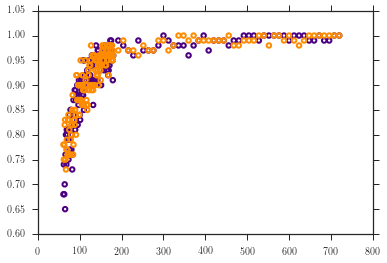

In [147]:
plt.scatter(AllAges[60:],sobs60_all[60:]/100.,facecolors='None',edgecolors='indigo',linewidth=2)
plt.scatter(AllAges[60:],sobs90_all[60:]/100.,facecolors='None',edgecolors='darkorange',linewidth=2)

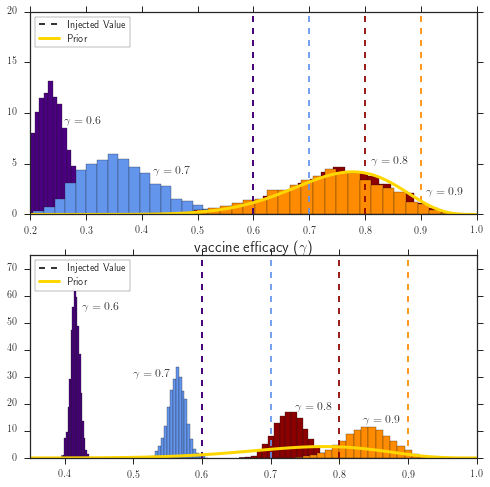

In [148]:
#V_eff: injected and recovered values for effective vaccination, as well as the prior.

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
ax0, ax1 = axes.flatten()

x = np.linspace(0,1,100)
y = scipy.stats.beta.pdf(x,a=15.,b=5.)
#veff50,b,c = plt.hist(samples50[:,6],bins=20, normed=True)
#plt.figure(figsize=(4*2,3*2))
veff60,b,c = ax1.hist(samples60[:,6],bins=20, normed=True, color ='indigo')
ax1.axvline(0.6,c='k',ls='--',label='Injected Value')
ax1.axvline(0.6,c='indigo',ls='--')
veff70,b,c = ax1.hist(samples70[:,6],bins=20, normed=True, color = 'cornflowerblue')
ax1.axvline(0.7,c='cornflowerblue',ls='--')
veff80,b,c = ax1.hist(samples80[:,6],bins=20, normed=True, color = 'darkred')
ax1.axvline(0.8,c='darkred',ls='--')
veff90,b,c = ax1.hist(samples90[:,6],bins=20, normed=True, color = 'darkorange')
ax1.axvline(0.9,c='darkorange',ls='--')
#veff100,b,c = plt.hist(samples100[:,6],bins=20, normed=True, color ='darkdarkgreen')
ax1.plot(x,y,color='gold',lw=3, label='Prior')
ax1.legend(loc='upper left',frameon=True)
ax1.annotate('$\gamma = 0.6$',(0.425,55),fontsize=12)
ax1.annotate('$\gamma = 0.7$',(0.5,30),fontsize=12)
ax1.annotate('$\gamma = 0.8$',(0.735,18),fontsize=12)
ax1.annotate('$\gamma = 0.9$',(0.835,13),fontsize=12)
ax1.set_xlim(0.35,1)
ax1.set_ylim(0,75)
#ax0.set_xlabel('vaccine efficacy ($\gamma$)',fontsize=15)

veff60,b,c = ax0.hist(samplesvc60[:,6],bins=30, normed=True, color ='indigo')
ax0.axvline(0.6,c='k',ls='--',label='Injected Value')
ax0.axvline(0.6,c='indigo',ls='--')
veff70,b,c = ax0.hist(samplesvc70[:,6],bins=30, normed=True, color = 'cornflowerblue')
ax0.axvline(0.7,c='cornflowerblue',ls='--')
veff80,b,c = ax0.hist(samplesvc80[:,6],bins=30, normed=True, color = 'darkred')
ax0.axvline(0.8,c='darkred',ls='--')
veff90,b,c = ax0.hist(samplesvc90[:,6],bins=30, normed=True, color = 'darkorange')
ax0.axvline(0.9,c='darkorange',ls='--')
#veff100,b,c = plt.hist(samples100[:,6],bins=20, normed=True, color ='darkdarkgreen')
ax0.plot(x,y,color='gold',lw=3, label='Prior')
ax0.legend(loc='upper left',frameon=True)
ax0.annotate('$\gamma = 0.6$',(0.26,9),fontsize=12)
ax0.annotate('$\gamma = 0.7$',(0.42,4),fontsize=12)
ax0.annotate('$\gamma = 0.8$',(0.81,5),fontsize=12)
ax0.annotate('$\gamma = 0.9$',(0.91,2),fontsize=12)
ax0.set_xlim(0.2,1)
ax0.set_ylim(0,20)
ax0.set_xlabel('vaccine efficacy ($\gamma$)',fontsize=15)

plt.savefig('veff_fakedata.png',dpi=300,bbox_inches="tight")

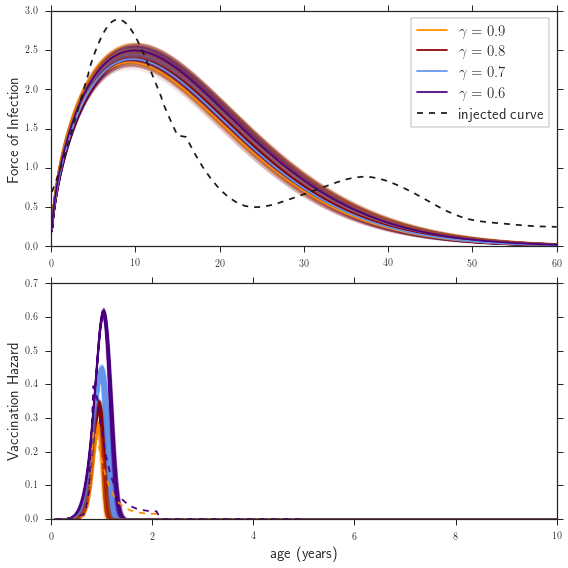

In [121]:
#Look at vacchazard and foi:
foiinj = np.genfromtxt('../Data/foi_injected.csv',delimiter=',') #injected foi
vhdat = np.genfromtxt('../Data/pvaccCov90_30.csv',delimiter=' ') #injected vacc. hazard
vaxhazdat = vhdat[:,1].copy()
vhinj = np.zeros(60)
i=0
for vh in vhdat[:,1]:
    vhinj[i] = vh
    i += 1

#Set up x axes
xplot = np.linspace(1,60,60)
nspace = 2000
x = np.linspace(1,60*12,nspace)

#arrays for force of infection
foi50 = np.zeros(nspace)
foi60 = np.zeros(nspace)
foi70 = np.zeros(nspace)
foi80 = np.zeros(nspace)
foi90 = np.zeros(nspace)

#arrays for vaccination hazard
vhaz60 = np.zeros(nspace)
vhaz70 = np.zeros(nspace)
vhaz80 = np.zeros(nspace)
vhaz90 = np.zeros(nspace)

#number of curves to plot, l is for the random number generator
l = len(samples60[:,0])
l = 2000
nplot = 300
#set up subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
ax0, ax1 = axes.flatten()

for k in range(nplot):
    index = np.random.randint(l)
    
    va60 = samplesvc60[index,0] 
    vb60 = samplesvc60[index,1] 
    vh60 = samplesvc60[index,2]  
    fa60 = samplesvc60[index,3] 
    fb60 = samplesvc60[index,4] 
    fh60 = samplesvc60[index,5] 
    ve60 = samplesvc60[index,6]
    
    va70 = samplesvc70[index,0] 
    vb70 = samplesvc70[index,1] 
    vh70 = samplesvc70[index,2]  
    fa70 = samplesvc70[index,3] 
    fb70 = samplesvc70[index,4] 
    fh70 = samplesvc70[index,5] 
    ve70 = samplesvc70[index,6]
    
    va80 = samplesvc80[index,0] 
    vb80 = samplesvc80[index,1] 
    vh80 = samplesvc80[index,2] 
    fa80 = samplesvc80[index,3] 
    fb80 = samplesvc80[index,4] 
    fh80 = samplesvc80[index,5] 
    ve80 = samplesvc80[index,6] 

    
    va90 = samplesvc90[index,0] 
    vb90 = samplesvc90[index,1] 
    vh90 = samplesvc90[index,2] 
    fa90 = samplesvc90[index,3] 
    fb90 = samplesvc90[index,4] 
    fh90 = samplesvc90[index,5] 
    ve90 = samplesvc90[index,6] 

    
    j = 0
    for i in x:
        a = float(i)
        foi90[j] = fh90*(a/fb90)**(fa90-1.)*np.exp(-(a/fb90)**(fa90))
        vhaz90[j] = vh90*(a/vb90)**(va90-1.)*np.exp(-(a/vb90)**(va90))
        
        foi80[j] = fh80*(a/fb80)**(fa80-1.)*np.exp(-(a/fb80)**(fa80))
        vhaz80[j] = vh80*(a/vb80)**(va80-1.)*np.exp(-(a/vb80)**(va80))
        
        foi70[j] = fh70*(a/fb70)**(fa70-1.)*np.exp(-(a/fb70)**(fa70))
        vhaz70[j] = vh70*(a/vb70)**(va70-1.)*np.exp(-(a/vb70)**(va70))
        
        foi60[j] = fh60*(a/fb60)**(fa60-1.)*np.exp(-(a/fb60)**(fa60))
        vhaz60[j] = vh60*(a/vb60)**(va60-1.)*np.exp(-(a/vb60)**(va60))
        j += 1
    ax0.plot(x/12.,foi90,alpha=0.1,color='darkorange')
    ax0.plot(x/12.,foi60,alpha=0.1,color='indigo')
    ax0.plot(x/12.,foi80,alpha=0.1,color='darkred')
    ax0.plot(x/12.,foi70,alpha=0.1,color='cornflowerblue')
    ax1.plot(x/12.,vhaz90,alpha=0.1,color='darkorange',linewidth=1)
    ax1.plot(x/12.,vhaz60,alpha=0.1,color='indigo',linewidth=1)
    ax1.plot(x/12.,vhaz80,alpha=0.1,color='darkred')
    ax1.plot(x/12.,vhaz70,alpha=0.1,color='cornflowerblue')

ax0.plot(x/12.,foi90,alpha=1.,color='darkorange',label='$\gamma = 0.9$')   
ax0.plot(x/12.,foi80,alpha=1.,color='darkred',label='$\gamma = 0.8$')
ax0.plot(x/12.,foi70,alpha=1.,color='cornflowerblue',label='$\gamma = 0.7$')
ax0.plot(x/12.,foi60,alpha=1.,color='indigo',label='$\gamma = 0.6$')
ax0.plot(foiinj[:,0]/12.,foiinj[:,1]/10.,'k--',label='injected curve')
ax1.plot(xplot/12.,vhinj/0.9,color='darkorange', linestyle='--')
ax1.plot(xplot/12.,vhinj/0.6,color='indigo', linestyle='--')
ax0.set_ylabel('Force of Infection',fontsize=15)
ax1.set_ylabel('Vaccination Hazard',fontsize=15)
ax0.legend(fontsize=15,frameon=True)
ax1.set_xlim(0,10)
plt.xlabel('age (years)',fontsize=15)
fig.tight_layout()
plt.savefig('foivhaz_fakedata_vaxserocase.pdf',bbox_inches='tight')

KeyboardInterrupt: 

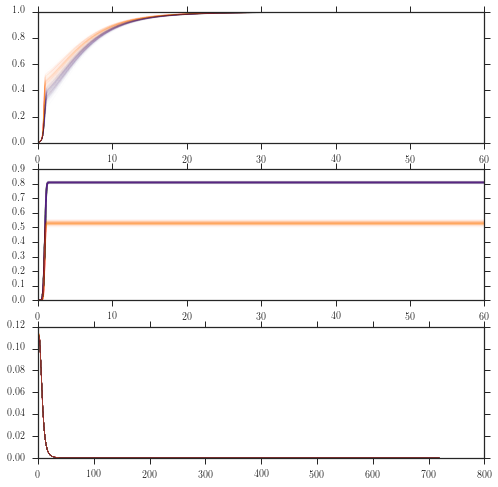

In [145]:
#Look at predicted vaccination level, seroprevalence, and case count, plotted along with actual data.
nspace = 1200
x = np.linspace(1,60*12,nspace)
xplot = np.linspace(1,60,60)
xy = np.linspace(1,60,nspace)
cplot9 = np.zeros(nspace)
vplot9 = np.zeros(nspace)
splot9 = np.zeros(nspace)
cplot6 = np.zeros(nspace)
vplot6 = np.zeros(nspace)
splot6 = np.zeros(nspace)

l = len(samples60[:,0])
nplot = 300
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,8))
ax0, ax1, ax2 = axes.flatten()
for k in range(nplot):
    index = np.random.randint(l)
    
    va60 = samplesvc60[index,0] 
    vb60 = samplesvc60[index,1] 
    vh60 = samplesvc60[index,2]  
    fa60 = samplesvc60[index,3] 
    fb60 = samplesvc60[index,4] 
    fh60 = samplesvc60[index,5] 
    ve60 = samplesvc60[index,6]
    
    va90 = samplesvc90[index,0] 
    vb90 = samplesvc90[index,1] 
    vh90 = samplesvc90[index,2] 
    fa90 = samplesvc90[index,3] 
    fb90 = samplesvc90[index,4] 
    fh90 = samplesvc90[index,5] 
    ve90 = samplesvc90[index,6] 
    
    
    j = 0
    for i in x:
        a = float(i)
        vplot6[j] = 1. - np.exp(-vh60*(1. - np.exp(-(a/vb60)**va60)))
        splot6[j] = 1.0 - np.exp(-ve60*vh60*(1.-np.exp(-(i/vb60)**va60)) - fh60*(1. - np.exp((-(i/fb60)**fa60))))
        cplot6[j] = (1.-np.exp(-(fh60*fa60/fb60*(a*12./fb60))**(fa60-1.)*np.exp(-(a*12./fb60)**fa60)))\
        *(np.exp(-ve60*vh60*(1.-np.exp(-(a*12./vb60)**va60))-fh60*(1.-np.exp(-(a*12./fb60)**fa60))))
        
        vplot9[j] = 1. - np.exp(-vh90*(1. - np.exp(-(a/vb90)**va90)))
        splot9[j] = 1.0 - np.exp(-ve90*vh90*(1.-np.exp(-(i/vb90)**va90)) - fh90*(1. - np.exp((-(i/fb90)**fa90))))
        cplot9[j] = (1.-np.exp(-(fh90*fa90/fb90*((a*12.)/fb90))**(fa90-1.)*np.exp(-((a*12.)/fb90)**fa90)))\
        *(np.exp(-ve90*vh90*(1.-np.exp(-((a*12.)/vb90)**va90))-fh90*(1.-np.exp(-((a*12.)/fb90)**fa90))))
        j += 1
    ax1.plot(x/12,vplot6,alpha=0.01,color='indigo')
    ax0.plot((x-1)/12,splot6,alpha=0.01,color='indigo',linewidth=1)
    ax2.plot(x-1,cplot6/(sum(cplot6)*(x[1]-x[0])),alpha=0.01,color='indigo',linewidth=1)
    
    ax1.plot(x/12,vplot9,alpha=0.01,color='darkorange')
    ax0.plot((x-1)/12,splot9,alpha=0.01,color='darkorange',linewidth=1)
    ax2.plot(x-1,cplot9/(sum(cplot9)*(x[1]-x[0])),alpha=0.01,color='darkorange',linewidth=1)
    
ax0.scatter(AllAges[60:]/12.,sobs60_all[60:]/100.,facecolors='None',edgecolors='indigo',linewidth=2)
ax0.scatter(AllAges[60:]/12.,sobs90_all[60:]/100.,facecolors='None',edgecolors='darkorange',linewidth=2)
        
ax1.plot(xplot/12.,vobs60.astype(float)/vtry60.astype(float), color ='indigo',linestyle='none',marker='o')
ax0.plot(xplot/12.,sobs60.astype(float)/stry60.astype(float),color='indigo',linestyle='none',marker='o')
ax2.plot(cobs60.astype(float)/total_cases60,color='indigo',linestyle='none',marker='o')

ax1.plot(xplot/12.,vobs90.astype(float)/vtry90.astype(float), color ='darkorange',linestyle='none',marker='o')
ax0.plot(xplot/12.,sobs90.astype(float)/stry90.astype(float),color='darkorange',linestyle='none',marker='o')
ax2.plot(cobs90.astype(float)/total_cases90,color='darkorange',linestyle='none',marker='o')

ax1.set_ylabel('vaccination probability',fontsize=15)
ax0.set_ylabel('seroprevalence',fontsize=15)
ax2.set_ylabel('case distribution',fontsize=15)
ax2.set_xlabel('age (years)',fontsize=15)

ax1.set_xlim(0,30)
ax0.set_xlim(0,30)
ax2.set_xlim(0,30)
fig.tight_layout()
plt.savefig('vsc_simdata.pdf',bbox_inches='tight')

#### Supplementary Fake Data: 

What if we have more sero/vacc survey data? 

In [3]:
#Load in chains run using all three datasets from fake data:
samples = []
i = 0
burnin = 1000
for line in open('chains/fakedata/AllAges/Baseline/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samplesBL = np.array(samples)
samplesBL = samplesBL.astype(float)

samples = []
i = 0
for line in open('chains/fakedata/AllAges/HighSampling/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samplesHigh = np.array(samples)
samplesHigh = samplesHigh.astype(float)

samples = []
i = 0
for line in open('chains/fakedata/AllAges/HighSampling_young/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samplesHighYoung = np.array(samples)
samplesHighYoung = samplesHighYoung.astype(float)

samples = []
i = 0
for line in open('chains/fakedata/AllAges/AvgSampling/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samplesAvg = np.array(samples)
samplesAvg = samplesAvg.astype(float)

samples = []
i = 0
for line in open('chains/fakedata/AllAges/SameTotal/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samplesST = np.array(samples)
samplesST = samplesST.astype(float)


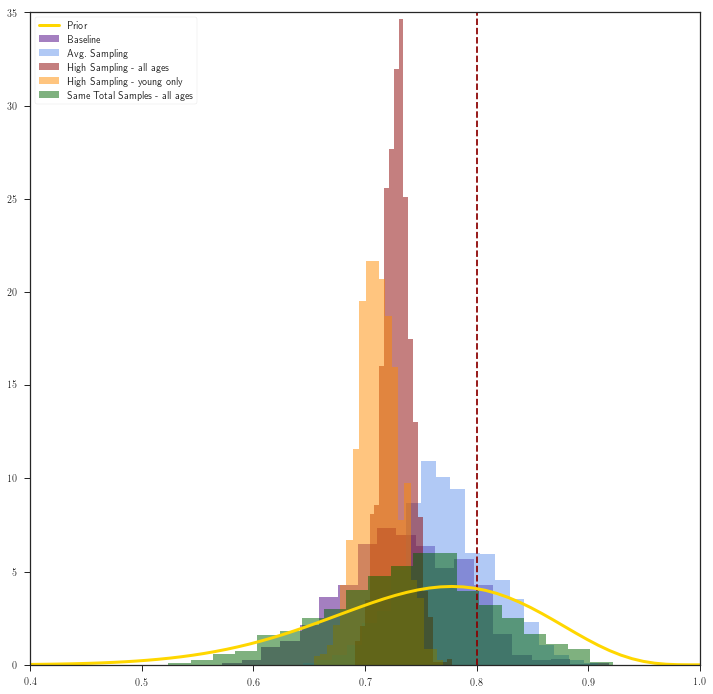

In [19]:
#V_eff: injected and recovered values for effective vaccination, as well as the prior.

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

x = np.linspace(0,1,100)
y = scipy.stats.beta.pdf(x,a=15.,b=5.)
#veff50,b,c = plt.hist(samples50[:,6],bins=20, normed=True)
#plt.figure(figsize=(4*2,3*2))
veff60,b,c = ax1.hist(samplesBL[:,6],bins=20, normed=True, color ='indigo', alpha=0.5, label='Baseline')
veff70,b,c = ax1.hist(samplesAvg[:,6],bins=20, normed=True, color = 'cornflowerblue', alpha=0.5,\
                     label = 'Avg. Sampling')
veff80,b,c = ax1.hist(samplesHigh[:,6],bins=20, normed=True, color = 'darkred', alpha=0.5, \
                      label = 'High Sampling - all ages')
ax1.axvline(0.8,c='darkred',ls='--')
veff90,b,c = ax1.hist(samplesHighYoung[:,6],bins=20, normed=True, color = 'darkorange', alpha=0.5, \
                     label = 'High Sampling - young only')
veff90,b,c = ax1.hist(samplesST[:,6],bins=20, normed=True, color = 'darkgreen', alpha=0.5, \
                     label = 'Same Total Samples - all ages')
ax1.plot(x,y,color='gold',lw=3, label='Prior')
ax1.legend(loc='upper left',frameon=True)
ax1.set_xlim(0.4,1)
ax1.set_ylim(0,35)

plt.savefig('veff_differentsero.png')

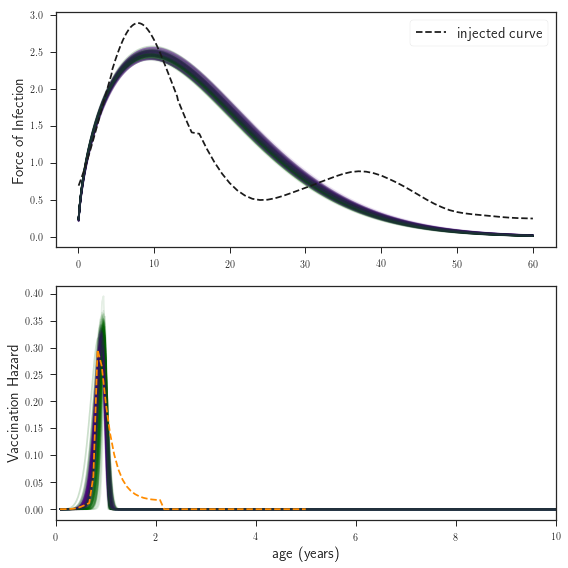

In [29]:
#Look at vacchazard and foi:
foiinj = np.genfromtxt('../Data/foi_injected.csv',delimiter=',') #injected foi
vhdat = np.genfromtxt('../Data/pvaccCov90_30.csv',delimiter=' ') #injected vacc. hazard
vaxhazdat = vhdat[:,1].copy()
vhinj = np.zeros(60)
i=0
for vh in vhdat[:,1]:
    vhinj[i] = vh
    i += 1

#Set up x axes
xplot = np.linspace(1,60,60)
nspace = 2000
x = np.linspace(1,60*12,nspace)

#arrays for force of infection
foi50 = np.zeros(nspace)
foi60 = np.zeros(nspace)
foi70 = np.zeros(nspace)
foi80 = np.zeros(nspace)
foi90 = np.zeros(nspace)
foiHY = np.zeros(nspace)

#arrays for vaccination hazard
vhaz60 = np.zeros(nspace)
vhaz70 = np.zeros(nspace)
vhaz80 = np.zeros(nspace)
vhaz90 = np.zeros(nspace)
vhazHY = np.zeros(nspace)

#number of curves to plot, l is for the random number generator
#l = len(samples60[:,0])
l = 1000
nplot = 100
#set up subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
ax0, ax1 = axes.flatten()

for k in range(nplot):
    index = np.random.randint(l)
    
    va60 = samplesBL[index,0] 
    vb60 = samplesBL[index,1] 
    vh60 = samplesBL[index,2]  
    fa60 = samplesBL[index,3] 
    fb60 = samplesBL[index,4] 
    fh60 = samplesBL[index,5] 
    ve60 = samplesBL[index,6]
    
    va70 = samplesAvg[index,0] 
    vb70 = samplesAvg[index,1] 
    vh70 = samplesAvg[index,2]  
    fa70 = samplesAvg[index,3] 
    fb70 = samplesAvg[index,4] 
    fh70 = samplesAvg[index,5] 
    ve70 = samplesAvg[index,6]
    
    va80 = samplesST[index,0] 
    vb80 = samplesST[index,1] 
    vh80 = samplesST[index,2] 
    fa80 = samplesST[index,3] 
    fb80 = samplesST[index,4] 
    fh80 = samplesST[index,5] 
    ve80 = samplesST[index,6] 

    
    va90 = samplesHigh[index,0] 
    vb90 = samplesHigh[index,1] 
    vh90 = samplesHigh[index,2] 
    fa90 = samplesHigh[index,3] 
    fb90 = samplesHigh[index,4] 
    fh90 = samplesHigh[index,5] 
    ve90 = samplesHigh[index,6] 
    
    
    vaHY = samplesHighYoung[index,0] 
    vbHY = samplesHighYoung[index,1] 
    vhHY = samplesHighYoung[index,2] 
    faHY = samplesHighYoung[index,3] 
    fbHY = samplesHighYoung[index,4] 
    fhHY = samplesHighYoung[index,5] 
    veHY = samplesHighYoung[index,6]

    
    j = 0
    for i in x:
        a = float(i)
        foi90[j] = fh90*(a/fb90)**(fa90-1.)*np.exp(-(a/fb90)**(fa90))
        vhaz90[j] = vh90*(a/vb90)**(va90-1.)*np.exp(-(a/vb90)**(va90))
        
        foi80[j] = fh80*(a/fb80)**(fa80-1.)*np.exp(-(a/fb80)**(fa80))
        vhaz80[j] = vh80*(a/vb80)**(va80-1.)*np.exp(-(a/vb80)**(va80))
        
        foi70[j] = fh70*(a/fb70)**(fa70-1.)*np.exp(-(a/fb70)**(fa70))
        vhaz70[j] = vh70*(a/vb70)**(va70-1.)*np.exp(-(a/vb70)**(va70))
        
        foi60[j] = fh60*(a/fb60)**(fa60-1.)*np.exp(-(a/fb60)**(fa60))
        vhaz60[j] = vh60*(a/vb60)**(va60-1.)*np.exp(-(a/vb60)**(va60))
        
        foiHY[j] = fhHY*(a/fbHY)**(faHY-1.)*np.exp(-(a/fbHY)**(faHY))
        vhazHY[j] = vhHY*(a/vbHY)**(vaHY-1.)*np.exp(-(a/vbHY)**(vaHY))
        j += 1
    
    ax0.plot(x/12.,foi60,alpha=0.1,color='indigo')
    ax0.plot(x/12.,foi80,alpha=0.1,color='darkgreen')
    #ax0.plot(x/12.,foi70,alpha=0.1,color='cornflowerblue')
    #ax0.plot(x/12.,foi90,alpha=0.1,color='darkred')
    #ax0.plot(x/12.,foiHY,alpha=0.1,color='darkorange')
    
    
    ax1.plot(x/12.,vhaz60,alpha=0.1,color='indigo')
    ax1.plot(x/12.,vhaz80,alpha=0.1,color='darkgreen')
    #ax1.plot(x/12.,vhaz70,alpha=0.1,color='cornflowerblue')
    #ax1.plot(x/12.,vhaz90,alpha=0.1,color='darkred')
    #ax1.plot(x/12.,vhazHY,alpha=0.1,color='darkorange')

#ax0.plot(x/12.,foi90,alpha=1.,color='darkorange',label='$\gamma = 0.9$')   
#ax0.plot(x/12.,foi80,alpha=1.,color='darkred',label='$\gamma = 0.8$')
#ax0.plot(x/12.,foi70,alpha=1.,color='cornflowerblue',label='$\gamma = 0.7$')
#ax0.plot(x/12.,foi60,alpha=1.,color='indigo',label='$\gamma = 0.6$')
ax0.plot(foiinj[:,0]/12.,foiinj[:,1]/10.,'k--',label='injected curve')
ax1.plot(xplot/12.,vhinj/0.8,color='darkorange', linestyle='--')
#ax1.plot(xplot/12.,vhinj/0.6,color='indigo', linestyle='--')
ax0.set_ylabel('Force of Infection',fontsize=15)
ax1.set_ylabel('Vaccination Hazard',fontsize=15)
ax0.legend(fontsize=15,frameon=True)
ax1.set_xlim(0,10)
plt.xlabel('age (years)',fontsize=15)
fig.tight_layout()
plt.savefig('BL_ST_hazards.png')
#plt.savefig('foivhaz_fakedata_vaxserocase.pdf',bbox_inches='tight')

In [89]:
#Keeping the locations color-coded:
locs = ['BANDUNDU', 'EQUATEUR', 'KATANGA', 'KINSHASA', 'NKIVU', 'ORIENTALE', 'SKIVU', 'BASCONGO',\
         'KASAIOCC','KASAIOR', 'MANIEMA']
colors = ['darkorange','gold','green','blue','indigo','darkviolet','red','teal','grey','plum','firebrick']

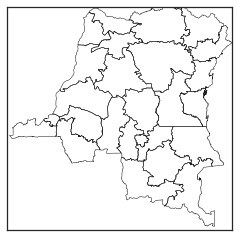

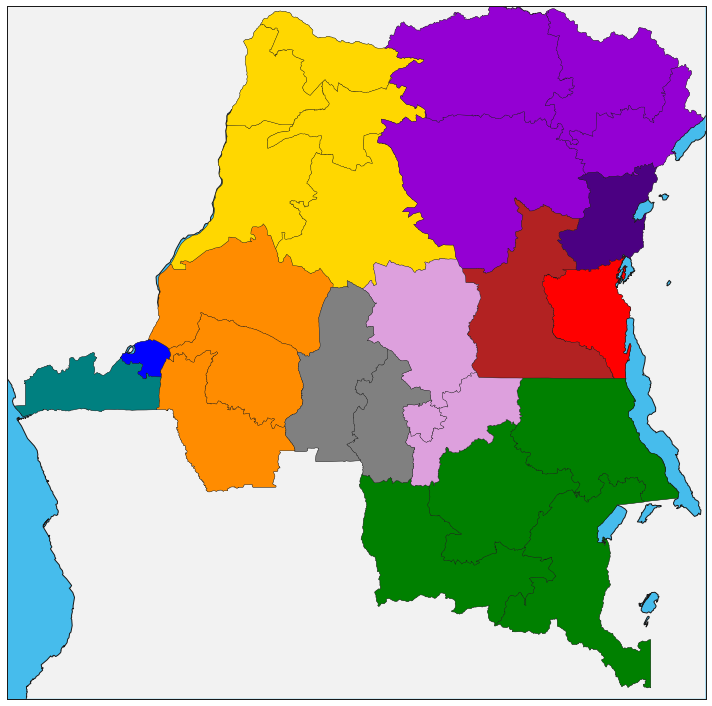

In [41]:
#Read in the geographic area for basemap
m = Basemap(resolution='i', # c, l, i, h, f or None (crude, low, intermediate, high)
            projection='merc', #mercator
            lat_0=54.5, lon_0=-4.36, #Coordinates of lower-left and upper-right. 
            urcrnrlon=31.33, urcrnrlat= 5.27, llcrnrlon=12.0, llcrnrlat=-13.75);
m.readshapefile('/Users/laurasampson/Work/shapefiles/DRC/GISunit/dps','areas') #DRC

#Set up a dataframe with polygons and province names
df_poly= pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.areas],
        'provname': [area['name'] for area in m.areas_info]
    })
df_poly['provname'] = map(lambda x: x.upper(), df_poly['provname'])
df_poly['provname'] = df_poly['provname'].map(lambda x: x.replace('-',''))
df_poly['provname'] = df_poly['provname'].map(lambda x: x.replace(' ',''))

#Need to add the old province name for each of the new provinces (there are now 26, used to be 11)
provtoprov = pd.read_csv('/Users/laurasampson/Work/shapefiles/DRC/GISunit/map_province_names.csv')
name = []
for pfrom in df_poly['provname']:
    pto = provtoprov.loc[provtoprov['from']==pfrom,'to'].iloc[0]
    name.append(pto)


df_poly= pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.areas],
        'provname': [area['name'] for area in m.areas_info],
        'name': [area for area in name]
    })
df_poly['provname'] = map(lambda x: x.upper(), df_poly['provname'])
df_poly['provname'] = df_poly['provname'].map(lambda x: x.replace('-',''))
df_poly['provname'] = df_poly['provname'].map(lambda x: x.replace(' ',''))
df_poly['name'] = df_poly['name'].map(lambda x: x.replace('SUDKIVU','SKIVU'))
df_poly['name'] = df_poly['name'].map(lambda x: x.replace('NORDKIVU','NKIVU'))
df_poly['name'] = df_poly['name'].map(lambda x: x.replace('KASAIORIENTAL','KASAIOR'))
df_poly['name'] = df_poly['name'].map(lambda x: x.replace('KASAIOCCIDENTAL','KASAIOCC'))

clist = []
#Now you need to match this to the color
for n in df_poly.name:
    j = locs.index(n)
    clist.append(colors[j])

#Finally, make the map
fig, ax = plt.subplots(figsize=(10,20));
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.readshapefile('/Users/laurasampson/Work/shapefiles/DRC/GISunit/dps','areas') #DRC
pc = PatchCollection(df_poly.shapes, zorder=2)
pc.set_facecolor(clist)
ax.add_collection(pc)
fig.tight_layout()
plt.savefig('ColorMap.pdf',dpi=100,bbox_inches='tight')

BANDUNDU 1989
EQUATEUR 1989
KATANGA 1989
KINSHASA 1399
NKIVU 1989
ORIENTALE 989
SKIVU 1989
BASCONGO 1490
KASAIOCC 1490
KASAIOR 1490
MANIEMA 2190


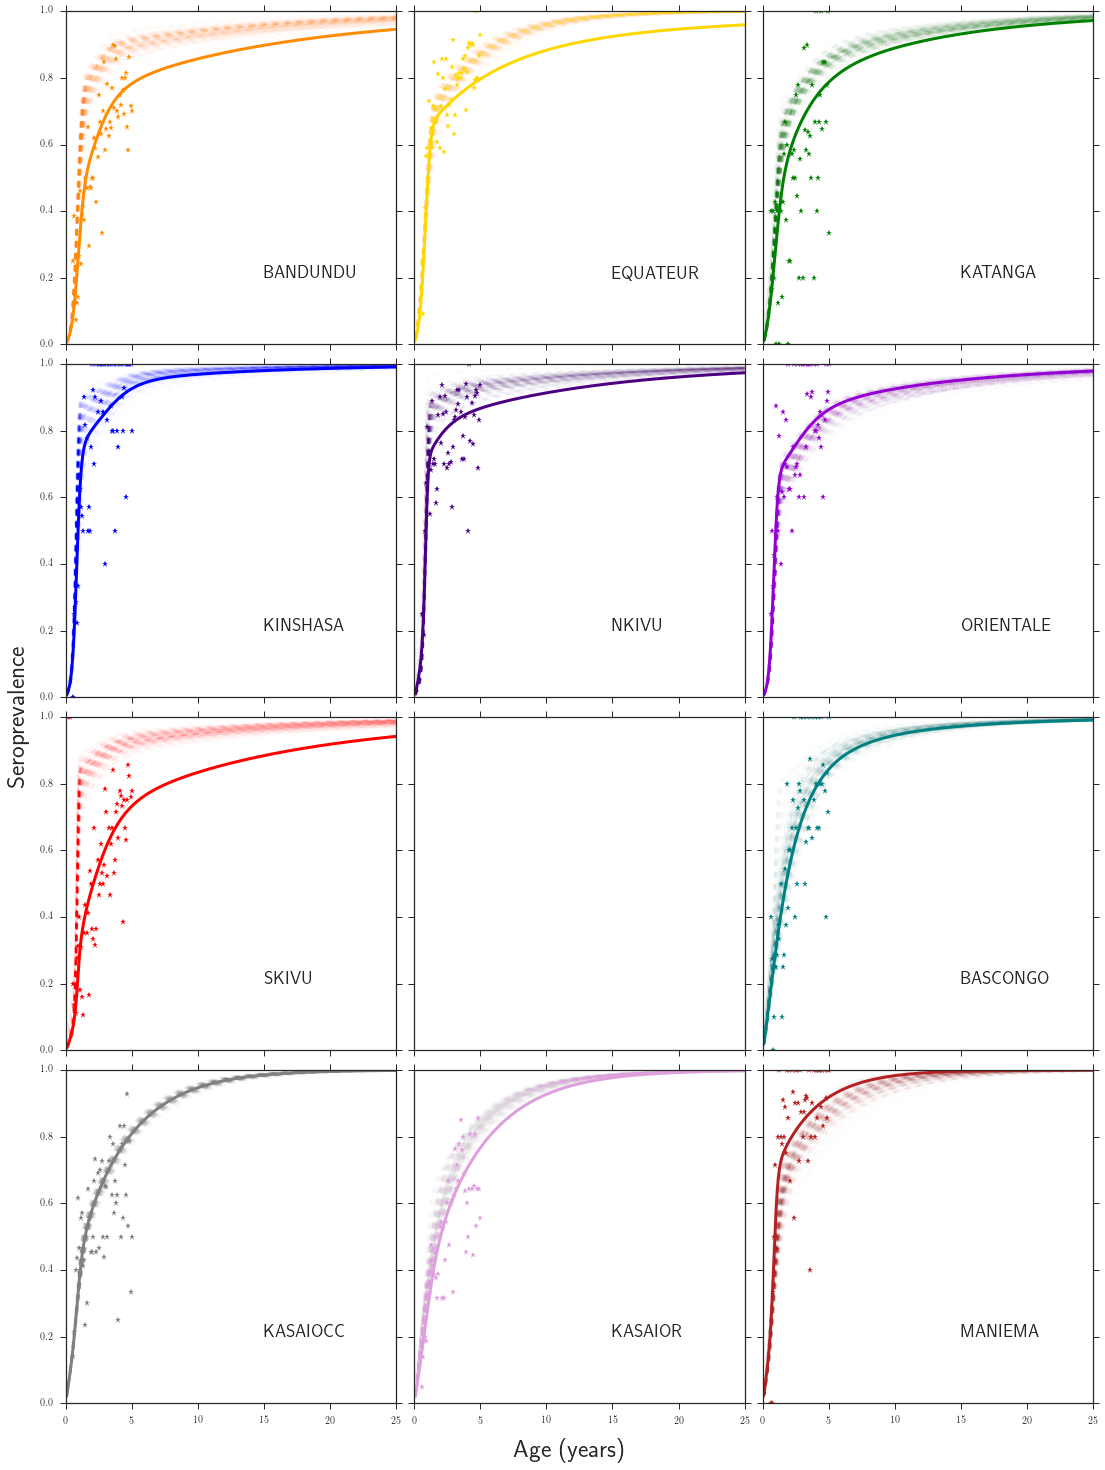

In [42]:
#First, the seroprevalence for each.:
burnin = 500
vobs_pandas = pd.read_csv('../Data/Xvax.csv')
vtrials_pandas = pd.read_csv('../Data/Nvax.csv')
sobs_pandas = pd.read_csv('../Data/YseroNew.csv')
strials_pandas = pd.read_csv('../Data/NseroNew.csv')
cases_pandas = pd.read_csv('../Data/reported_cases_lab.csv')


fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,20),sharex=True,sharey=True)
axis = axes.flatten()

nspace = 1000
x = np.linspace(1,25*12,nspace)
xplot = np.linspace(1,25*12,nspace)
xdata = np.linspace(1,60,60)

j = 0
for prov in locs:
    #Read in the actual data
    vobs = vobs_pandas.loc[:,prov]
    vtrial = vtrials_pandas.loc[:,prov]
    sobs = sobs_pandas.loc[:,prov]
    strial = strials_pandas.loc[:,prov]
    cases = cases_pandas.loc[:,prov]
    vo = vobs.values
    vt = vtrial.values
    so = sobs.values
    st = strial.values
    co = cases.values
    
    vobs = np.copy(vo)
    vtry = np.copy(vt)
    sobs = np.copy(so)
    stry = np.copy(st)
    cobs = np.copy(co)  
    vtry = np.array(vtry)   
    

    #Get the samples for this province
    samples = []
    if j>7:
        c = colors[j-1]
    else:
        c = colors[j]
    if j==7:
        j+= 1
    ax = axis[j]
    j += 1
    i = 0
    for line in open('chains/BFtest/'+prov+'/chain_1.txt','r'):
        sample = line.split()
        if i> burnin:
            samples.append(sample)
        i += 1
    if j>7:
        samples = []
        for line in open('chains/BFtest/c_only/'+prov+'/chain_1.txt','r'):
            sample = line.split()
            if i> burnin:
                samples.append(sample)
            i += 1
    samples = np.array(samples)
    samples = samples.astype(float)
    print prov, len(samples)
    
    snosero = []
    i = 0
    for line in open('chains/BFtest/nosero/'+prov+'/chain_1.txt','r'):
        sample = line.split()
        if i> burnin:
            snosero.append(sample)
        i += 1
    if j>7 or prov=='EQUATEUR':
        snosero = []
        for line in open('chains/BFtest/nosero/c_only/'+prov+'/chain_1.txt','r'):
            sample = line.split()
            if i> burnin:
                snosero.append(sample)
            i += 1
    snosero = np.array(snosero)
    snosero = snosero.astype(float)
    
    sero = np.zeros(nspace)
    nosero = np.zeros(nspace)

    #l = len(samples[:,0])
    l = 900
    nplot = 300

    for k in range(nplot):
        index = np.random.randint(l)

        va = samples[index,0] 
        vb = samples[index,1] 
        vh = samples[index,2]  
        fa = samples[index,3] 
        fb = samples[index,4] 
        fh = samples[index,5] 
        ve = samples[index,6]
        con = samples[index,7]
        alph = samples[index,8]
        
        vans = snosero[index,0] 
        vbns = snosero[index,1] 
        vhns = snosero[index,2]  
        fans = snosero[index,3] 
        fbns = snosero[index,4] 
        fhns = snosero[index,5] 
        vens = snosero[index,6]
        conns = snosero[index,7]
        alphns = snosero[index,8]
        
        if j>8:
            alph = 0.
             
        m = 0
        for i in x:
            a = float(i)
            if j<= 7 and prov != 'EQUATEUR':
                sero[m] += 1. - np.exp(-vh*ve*(1. - np.exp(-(a/vb)**va)) - (alph)*fh*(1. - np.exp(-(a/fb)**fa))-con*a)
                nosero[m] = 1. - np.exp(-vhns*vens*(1. - np.exp(-(a/vbns)**vans))\
                                    - (alphns)*fhns*(1. - np.exp(-(a/fbns)**fans))-conns*a)
            if j>7 or prov=='EQUATEUR':
                sero[m] += 1. - np.exp(-vh*ve*(1. - np.exp(-(a/vb)**va))-con*a)
                nosero[m] = 1. - np.exp(-vhns*vens*(1. - np.exp(-(a/vbns)**vans))-conns*a)
            m += 1
        ax.plot(x/12.,nosero,alpha=0.01,color=c,linestyle='dashed')
        
    ax.plot(xdata/12.,sobs.astype(float)/stry.astype(float),color=c,marker='*',linestyle='none')
    sero /= nplot
    ax.plot(x/12.,sero,alpha=1.,color=c,linewidth=3)
    ax.annotate(prov,(15,0.2),fontsize=18)

fig.text(-0.01, 0.5, 'Seroprevalence', ha='center', va='center', rotation='vertical',fontsize=25)
fig.text(0.5, -0.01, 'Age (years)', ha='center', va='center', rotation='horizontal',fontsize=25)
fig.tight_layout()
plt.savefig('Seroprevalence.png',dpi=300,bbox_inches="tight")

BANDUNDU 1989
BANDUNDU 989
EQUATEUR 1989
EQUATEUR 1490
KATANGA 1989
KATANGA 989
KINSHASA 1399
KINSHASA 989
NKIVU 1989
NKIVU 989
ORIENTALE 989
ORIENTALE 989
SKIVU 1989
SKIVU 989
BASCONGO 1490
BASCONGO 1490
KASAIOCC 1490
KASAIOCC 1490
KASAIOR 1490
KASAIOR 1490
MANIEMA 2190
MANIEMA 1490


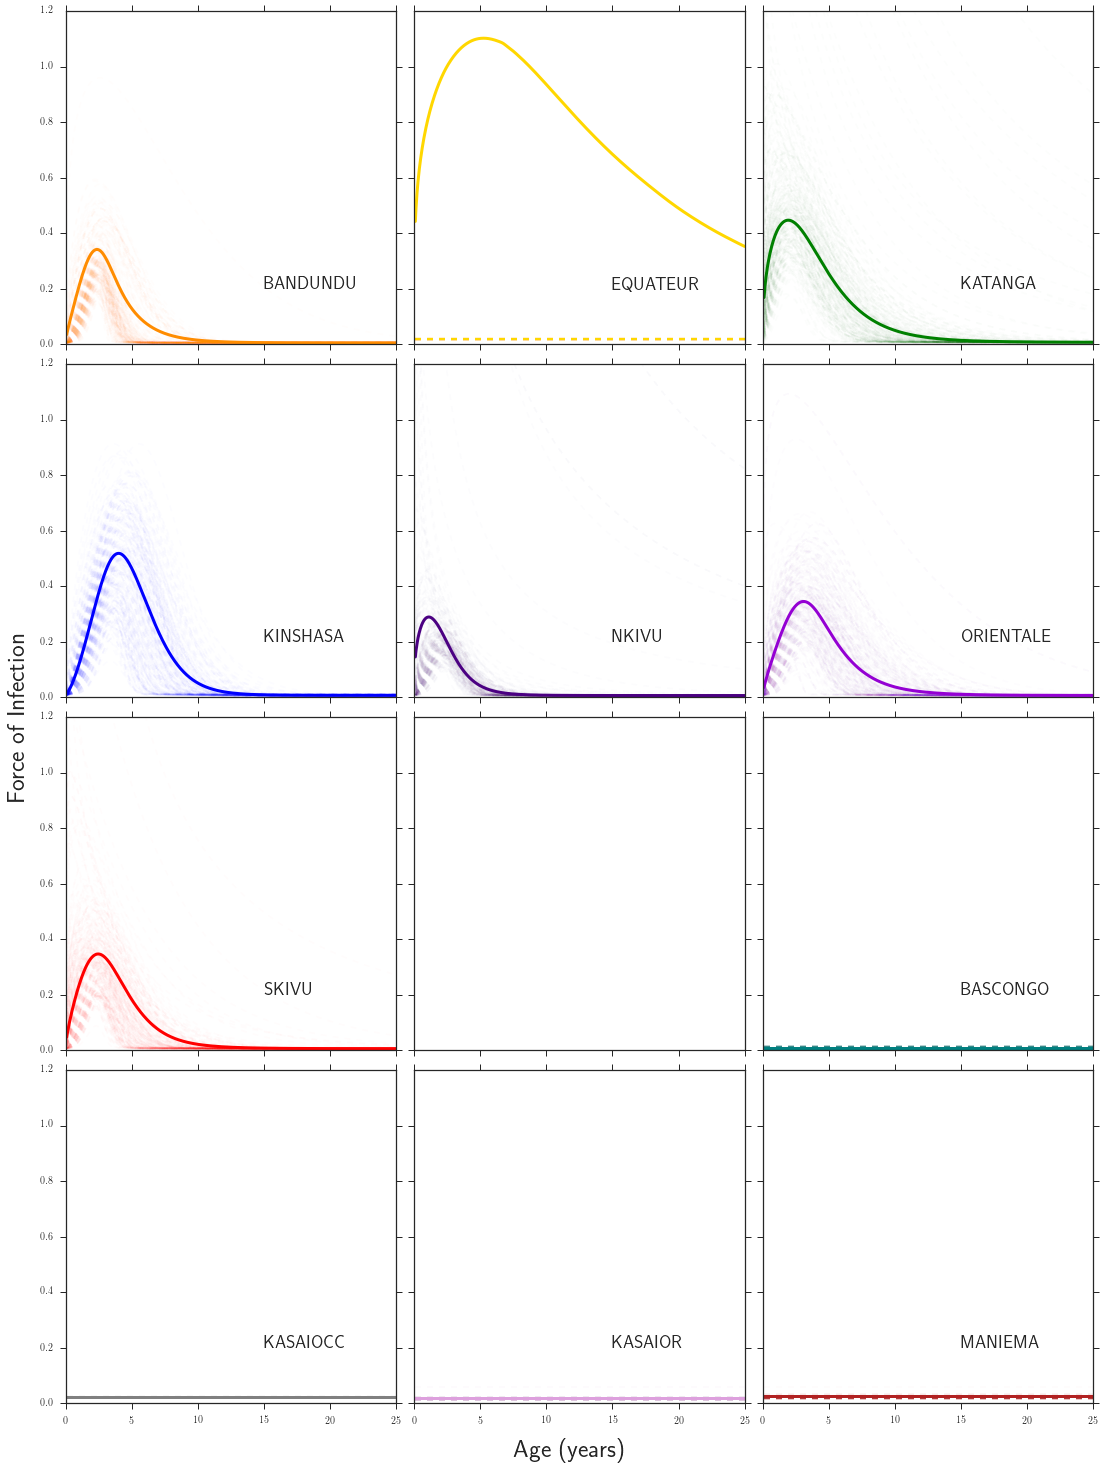

In [15]:
#FOI for each, with and without serology:
burnin = 500
vobs_pandas = pd.read_csv('../Data/Xvax.csv')
vtrials_pandas = pd.read_csv('../Data/Nvax.csv')
sobs_pandas = pd.read_csv('../Data/YseroNew.csv')
strials_pandas = pd.read_csv('../Data/NseroNew.csv')
cases_pandas = pd.read_csv('../Data/reported_cases_lab.csv')
xplot = np.linspace(1,25,25)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,20),sharex=True,sharey=True)
axis = axes.flatten()

nspace = 1000
x = np.linspace(1,25*12,nspace)
noy2 = [0,1,3,4,6,8,9]

b = 0
j = 0
for prov in locs:
    #Read in the actual data
    vobs = vobs_pandas.loc[:,prov]
    vtrial = vtrials_pandas.loc[:,prov]
    sobs = sobs_pandas.loc[:,prov]
    strial = strials_pandas.loc[:,prov]
    cases = cases_pandas.loc[:,prov]
    vo = vobs.values
    vt = vtrial.values
    so = sobs.values
    st = strial.values
    co = cases.values
    
    vobs = np.copy(vo)
    vtry = np.copy(vt)
    sobs = np.copy(so)
    stry = np.copy(st)
    cobs = np.copy(co)  
    vtry = np.array(vtry)   
    

    #Get the samples for this province
    samples = []
    if j>7:
        c = colors[j-1]
    else:
        c = colors[j]
    if j==7:
        j+= 1
    ax = axis[j]
    j += 1
    i = 0
    for line in open('chains/BFtest/'+prov+'/chain_1.txt','r'):
        sample = line.split()
        if i> burnin:
            samples.append(sample)
        i += 1
    if j>7:
        samples = []
        for line in open('chains/BFtest/c_only/'+prov+'/chain_1.txt','r'):
            sample = line.split()
            if i> burnin:
                samples.append(sample)
            i += 1
    samples = np.array(samples)
    samples = samples.astype(float)
    print prov, len(samples)
    
    snosero = []
    i = 0
    for line in open('chains/BFtest/nosero/'+prov+'/chain_1.txt','r'):
        sample = line.split()
        if i> burnin:
            snosero.append(sample)
        i += 1
    if j>7 or prov=='EQUATEUR':
        snosero = []
        for line in open('chains/BFtest/nosero/c_only/'+prov+'/chain_1.txt','r'):
            sample = line.split()
            if i> burnin:
                snosero.append(sample)
            i += 1
    snosero = np.array(snosero)
    snosero = snosero.astype(float)
    
    foi = np.zeros(nspace)
    nsfoi = np.zeros(nspace)

    #l = len(samples[:,0])
    l = 900
    nplot = 300

    for k in range(nplot):
        index = np.random.randint(l)

        va = samples[index,0] 
        vb = samples[index,1] 
        vh = samples[index,2]  
        fa = samples[index,3] 
        fb = samples[index,4] 
        fh = samples[index,5] 
        ve = samples[index,6]
        con = samples[index,7]
        alph = samples[index,8]
        
        vans = snosero[index,0] 
        vbns = snosero[index,1] 
        vhns = snosero[index,2]  
        fans = snosero[index,3] 
        fbns = snosero[index,4] 
        fhns = snosero[index,5] 
        vens = snosero[index,6]
        conns = snosero[index,7]
        alphns = snosero[index,8]
        
        if j>8:
            alph = 0.
             
        m = 0
        for i in x:
            a = float(i)
            if j<= 7 and prov != 'EQUATEUR':
                foi[m] += alph*fh*(a/fb)**(fa-1.)*np.exp(-(a/fb)**(fa))+con
                nsfoi[m] = alphns*fhns*(a/fbns)**(fans-1.)*np.exp(-(a/fbns)**(fans))+conns
            if j>7 or prov=='EQUATEUR':
                foi[m] += con
                nsfoi[m] = conns
            if prov =='EQUATEUR':
                foi[m] += alph*fh*(a/fb)**(fa-1.)*np.exp(-(a/fb)**(fa))+con
            m += 1
        ax.plot(x/12.,nsfoi,alpha=0.01,color=c,linestyle='dashed')
    foi /= nplot
    ax.plot(x/12.,foi,alpha=1.,color=c,linewidth=3)
    ax.annotate(prov,(15,0.2),fontsize=18)
    ax.set_ylim(0,1.2)

fig.text(-0.01, 0.5, 'Force of Infection', ha='center', va='center', rotation='vertical',fontsize=25)
fig.text(0.5, -0.01, 'Age (years)', ha='center', va='center', rotation='horizontal',fontsize=25)
fig.tight_layout()
plt.savefig('ForceofInfection.png',dpi=200,bbox_inches="tight")

0 BANDUNDU
1 EQUATEUR
2 KATANGA
3 KINSHASA
4 NKIVU
5 ORIENTALE
6 SKIVU
7 BASCONGO
8 KASAIOCC
9 KASAIOR
10 MANIEMA


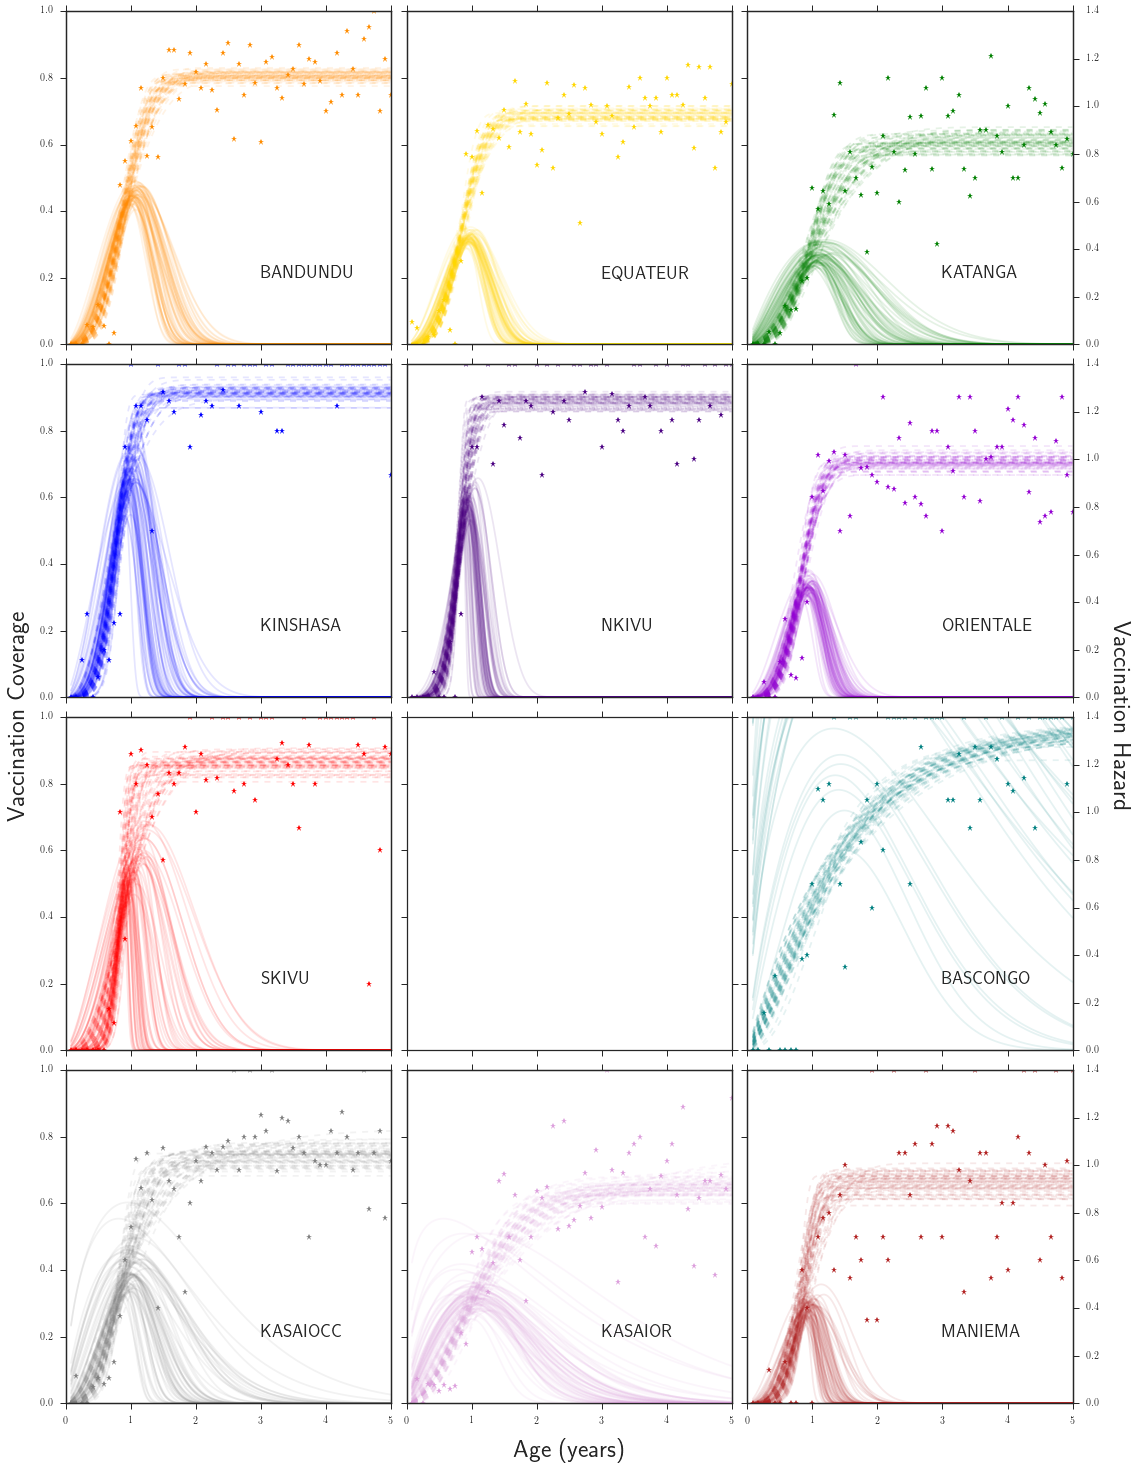

In [32]:
#Vaccination levels plus vaccination hazard
burnin = 500
vobs_pandas = pd.read_csv('../Data/Xvax.csv')
vtrials_pandas = pd.read_csv('../Data/Nvax.csv')
sobs_pandas = pd.read_csv('../Data/YseroNew.csv')
strials_pandas = pd.read_csv('../Data/NseroNew.csv')
cases_pandas = pd.read_csv('../Data/reported_cases_lab.csv')
xplot = np.linspace(1,25,25)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,20),sharex=True,sharey=True)
axis = axes.flatten()

nspace = 1000
x = np.linspace(1,5*12,nspace)

noy2 = [0,1,3,4,6,8,9]

j = 0
b = 0
for prov in locs:
    #Read in the actual data
    vobs = vobs_pandas.loc[:,prov]
    vtrial = vtrials_pandas.loc[:,prov]
    sobs = sobs_pandas.loc[:,prov]
    strial = strials_pandas.loc[:,prov]
    cases = cases_pandas.loc[:,prov]
    vo = vobs.values
    vt = vtrial.values
    so = sobs.values
    st = strial.values
    co = cases.values
    
    vobs = np.copy(vo)
    vtry = np.copy(vt)
    sobs = np.copy(so)
    stry = np.copy(st)
    cobs = np.copy(co)  
    vtry = np.array(vtry)   
    

    #Get the samples for this province
    samples = []
    if j>7:
        c = colors[j-1]
    else:
        c = colors[j]
    if j==7:
        j+= 1
    ax = axis[j]
    ax2 = ax.twinx()
    
    j += 1
    i = 0
    for line in open('chains/BFtest/'+prov+'/chain_1.txt','r'):
        sample = line.split()
        if i> burnin:
            samples.append(sample)
        i += 1
    if j>7:
        samples = []
        for line in open('chains/BFtest/c_only/'+prov+'/chain_1.txt','r'):
            sample = line.split()
            if i> burnin:
                samples.append(sample)
            i += 1
    samples = np.array(samples)
    samples = samples.astype(float)
    #print prov, len(samples)
    
    vacc = np.zeros(nspace)
    vhaz = np.zeros(nspace)

    l = len(samples[:,0])
    nplot = 60

    for k in range(nplot):
        index = np.random.randint(l)

        va = samples[index,0] 
        vb = samples[index,1] 
        vh = samples[index,2]  
        fa = samples[index,3] 
        fb = samples[index,4] 
        fh = samples[index,5] 
        ve = samples[index,6]
        con = samples[index,7]
        alph = samples[index,8]
        if j>7:
            alph = 0.
             
        m = 0
        for i in x:
            a = float(i)
            vhaz[m] = vh*(a/vb)**(va-1.)*np.exp(-(a/vb)**(va))
            vacc[m] = 1. - np.exp(-vh*(1. - np.exp(-(a/vb)**va)))
            m += 1
        ax.plot(x/12.,vacc,alpha=0.1,color=c,linestyle='dashed')
        ax2.plot(x/12.,vhaz,alpha=0.1,color=c)
        #ax2.set_yticks([],[])
    #ax.plot(xplot/12.,sobs[0:25].astype(float)/stry[0:25].astype(float),color=c,marker='*',linestyle='none')
    ax.annotate(prov,(3,0.2),fontsize=18)
    ax.set_ybound(0.,1.)
    ax2.set_ylim(0,1.4)
    ax.plot(xdata/12.,vobs.astype(float)/vtry.astype(float),color=c,marker='*',linestyle='none')
    print b, prov
    if np.isin(b,noy2):
        ax2.set_yticks([])
    b += 1

#ax0.set_ylabel('Force of Infection',fontsize=15)
#ax1.set_ylabel('Vaccination Hazard',fontsize=15)
#ax0.legend(fontsize=15,frameon=True)
#ax1.set_xlim(0,5)
fig.text(-0.01, 0.5, 'Vaccination Coverage', ha='center', va='center', rotation='vertical',fontsize=25)
fig.text(1.01, 0.5, 'Vaccination Hazard', ha='center', va='center', rotation=270,fontsize=25)
fig.text(0.5, -0.01, 'Age (years)', ha='center', va='center',fontsize=25)
#plt.xlabel('Age (years)',fontsize=15)
fig.tight_layout()
plt.savefig('VaccHazard.png',dpi=200,bbox_inches="tight")

darkorange BANDUNDU
gold EQUATEUR
green KATANGA
blue KINSHASA
indigo NKIVU
darkviolet ORIENTALE
red SKIVU
teal BASCONGO
grey KASAIOCC
plum KASAIOR
firebrick MANIEMA


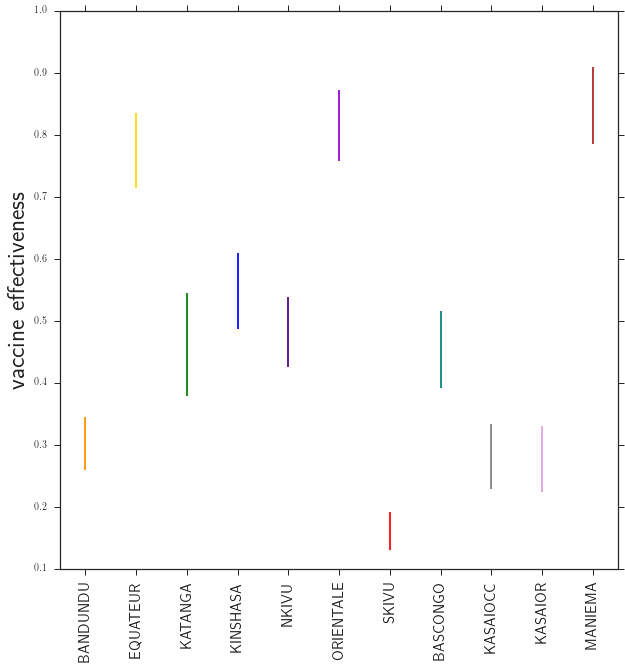

In [25]:
#Vaccine effectiveness
burnin = 500
vobs_pandas = pd.read_csv('../Data/Xvax.csv')
vtrials_pandas = pd.read_csv('../Data/Nvax.csv')
sobs_pandas = pd.read_csv('../Data/YseroNew.csv')
strials_pandas = pd.read_csv('../Data/NseroNew.csv')
cases_pandas = pd.read_csv('../Data/reported_cases_lab.csv')
xplot = np.linspace(1,25,25)

nspace = 1000
x = np.linspace(1,25*12,nspace)
plt.figure(figsize=(10,10))
j = 0
for prov in locs:
    
    #Get the samples for this province
    samples = []
    if j>7:
        c = colors[j-1]
    else:
        c = colors[j]
    if j==7:
        j+= 1
    j += 1
    i = 0
    for line in open('chains/BFtest/'+prov+'/chain_1.txt','r'):
        sample = line.split()
        if i> burnin:
            samples.append(sample)
        i += 1
    if j>7:
        samples = []
        for line in open('chains/BFtest/c_only/'+prov+'/chain_1.txt','r'):
            sample = line.split()
            if i> burnin:
                samples.append(sample)
            i += 1
    samples = np.array(samples)
    samples = samples.astype(float)
    
    l = len(samples[:,0])
    nplot = 100
    
    if j<8:
        r = j
    else:
        r = j-1
    
    vemean = np.mean(samples[:,6])
    vesig = np.sqrt(np.var(samples[:,6]))
    print c, prov
    plt.errorbar(r,vemean,xerr=None,yerr=vesig,color=c)

    #ax.plot(xplot/12.,sobs[0:25].astype(float)/stry[0:25].astype(float),color=c,marker='*',linestyle='none')
    
plt.xticks(np.linspace(1,11,11),locs,rotation='vertical',fontsize=15)
plt.xlim(0.5,11.5)
plt.ylabel('vaccine effectiveness',fontsize=25)

fig.tight_layout()
plt.savefig('Veff.png',dpi=125,bbox_inches="tight")

In [43]:
#Now, you want to calculate the integrated force of infection for the three different data combinations for each
#province. (just serology, vaccination plus case data, and all three.)
burnin = 500
nspace = 1000
x = np.linspace(1,10*12,nspace)
locs = ['BANDUNDU', 'EQUATEUR', 'KATANGA', 'KINSHASA', 'NKIVU', 'ORIENTALE', 'SKIVU', 'BASCONGO',\
         'KASAIOCC','KASAIOR', 'MANIEMA']

locs = ['BANDUNDU','EQUATEUR','KATANGA','KINSHASA' , 'NKIVU', 'ORIENTALE', 'SKIVU', 'BASCONGO',\
         'KASAIOCC','KASAIOR', 'MANIEMA']

risk = []    
j = 0
for prov in locs:
    #Get the samples for this province
    samples = []
    if j==7:
        j+= 1
    j += 1
    i = 0
    for line in open('chains/BFtest/'+prov+'/chain_1.txt','r'):
        sample = line.split()
        if i> burnin:
            samples.append(sample)
        i += 1
    if j>7:
        samples = []
        for line in open('chains/BFtest/c_only/'+prov+'/chain_1.txt','r'):
            sample = line.split()
            if i> burnin:
                samples.append(sample)
            i += 1
    samples = np.array(samples)
    samples = samples.astype(float)
    
    snosero = []
    i = 0
    for line in open('chains/BFtest/nosero/'+prov+'/chain_1.txt','r'):
        sample = line.split()
        if i> burnin:
            snosero.append(sample)
        i += 1
    if j>7 or prov=='EQUATEUR':
        snosero = []
        for line in open('chains/BFtest/nosero/c_only/'+prov+'/chain_1.txt','r'):
            sample = line.split()
            if i> burnin:
                snosero.append(sample)
            i += 1
    snosero = np.array(snosero)
    snosero = snosero.astype(float)
    
    sonlysero = []
    i = 0
    for line in open('chains/BFtest/onlysero/'+prov+'/chain_1.txt','r'):
        sample = line.split()
        if i> burnin:
            sonlysero.append(sample)
        i += 1

    sonlysero = np.array(sonlysero)
    sonlysero = sonlysero.astype(float)
    
    sero = np.zeros(nspace)
    nosero = np.zeros(nspace)
    onlysero = np.zeros(nspace)
    
    sumsero     = []
    sumnosero   = []
    sumonlysero = []

    l = 900
    nplot = 800
    n = 0
    for k in range(nplot):
        index = np.random.randint(l)
        index = -n

        va = samples[index,0] 
        vb = samples[index,1] 
        vh = samples[index,2]  
        fa = samples[index,3] 
        fb = samples[index,4] 
        fh = samples[index,5] 
        ve = samples[index,6]
        con = samples[index,7]
        alph = samples[index,8]
        
        vans = snosero[index,0] 
        vbns = snosero[index,1] 
        vhns = snosero[index,2]  
        fans = snosero[index,3] 
        fbns = snosero[index,4] 
        fhns = snosero[index,5] 
        vens = snosero[index,6]
        conns = snosero[index,7]
        alphns = snosero[index,8]
        
        vanso = sonlysero[index,0] 
        vbnso = sonlysero[index,1] 
        vhnso = sonlysero[index,2]
        venso = sonlysero[index,6]
        conos = sonlysero[index,7]
        
        if j>8:
            alph = 0.
             
        m = 0
        for i in x:
            a = float(i)
            onlysero[m] = conos
            if j<= 7 and prov != 'EQUATEUR':
                sero[m] = alph*fh*(a/fb)**(fa-1.)*np.exp(-(a/fb)**(fa))+con
                nosero[m] = alphns*fhns*(a/fbns)**(fans-1.)*np.exp(-(a/fbns)**(fans))+conns
            if j>7 or prov=='EQUATEUR':
                sero[m] = con
                nosero[m] = conns
            m += 1
        sumsero.append(np.sum(sero))
        sumnosero.append(np.sum(nosero))
        sumonlysero.append(np.sum(onlysero))
        n += 1
    sumsero = np.array(sumsero)
    sumnosero = np.array(sumnosero)
    sumonlysero = np.array(sumonlysero)
    medsero = np.median(sumsero)
    mednosero = np.median(sumnosero)
    medonlysero = np.median(sumonlysero)
    dx = x[1] - x[0]
    
    print  (medonlysero*dx), mednosero*dx, medsero*dx
    risk.append([medonlysero*dx,mednosero*dx,medsero*dx])


3.4252267964692162 9.120389271640033 11.899375747462217
2.348426045897965 2.3279220209702136 1.3955782112275348
3.004305312412065 28.386253674092213 27.95413571503151
6.778130145889782 30.968622226089966 30.64975337904724
2.0283969497110457 7.9869354290777945 11.326671217053438
5.746527428162194 18.864998916633635 19.34106910930821
2.7792692043254745 15.552476924502134 16.871515224923495
3.6575404731923036 1.0750516860290267 1.0191743429736295
0.8180991905801352 2.5452123106907907 2.5342382671566344
2.9065976513100953 1.9933559992443661 2.298316556209205
1.9803659478853242 2.560515200468006 3.1838173514180736


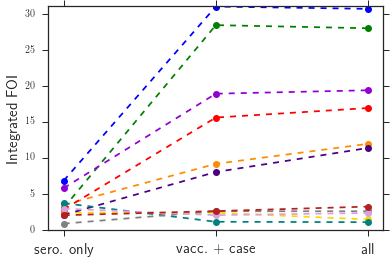

In [44]:
risk = np.array(risk)
plt.plot(risk[0,:], linestyle='--',marker='o',color=colors[0])
plt.plot(risk[1,:],linestyle='--',marker='o',color=colors[1])
plt.plot(risk[2,:],linestyle='--',marker='o',color=colors[2])
plt.plot(risk[3,:],linestyle='--',marker='o',color=colors[3])
plt.plot(risk[4,:],linestyle='--',marker='o',color=colors[4])
plt.plot(risk[5,:],linestyle='--',marker='o',color=colors[5])
plt.plot(risk[6,:],linestyle='--',marker='o',color=colors[6])
plt.plot(risk[7,:],linestyle='--',marker='o',color=colors[7])
plt.plot(risk[8,:],linestyle='--',marker='o',color=colors[8])
plt.plot(risk[9,:],linestyle='--',marker='o',color=colors[9])
plt.plot(risk[10,:],linestyle='--',marker='o',color=colors[10])
plt.xticks([0,1,2],['sero. only','vacc. + case','all'],rotation=0,fontsize=15)
plt.ylabel('Integrated FOI',fontsize=15)
plt.xlim(-0.1,2.1)
plt.ylim(0,31)
plt.savefig("RiskRank.png",dpi=200,bbox_inches='tight')

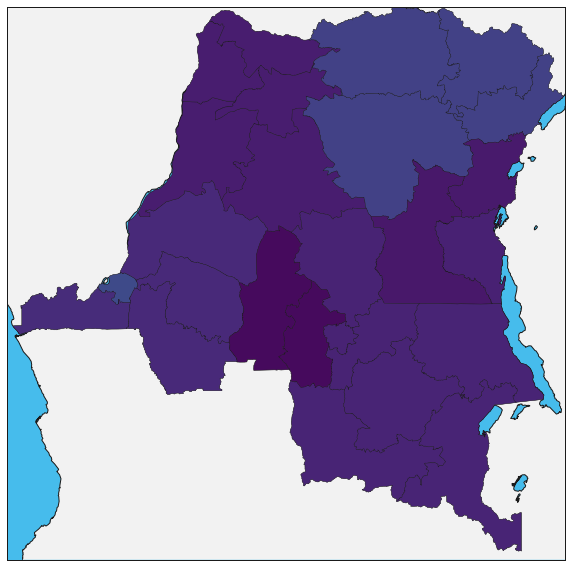

In [45]:
#Same map as before, but now color-coded by the risk calculated for sero only
m = Basemap(resolution='i', # c, l, i, h, f or None (crude, low, intermediate, high)
            projection='merc', #mercator
            lat_0=54.5, lon_0=-4.36, #Coordinates of lower-left and upper-right. 
            urcrnrlon=31.33, urcrnrlat= 5.27, llcrnrlon=12.0, llcrnrlat=-13.75);
#m.readshapefile('/Users/laurasampson/Work/shapefiles/DRC/GISunit/dps','areas') #DRC

cmap = plt.get_cmap('viridis')   #Correct choice for color map.
cmap.set_bad('k')
vmin = 0.
vmax = 30.
norm = Normalize(vmin,vmax)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
z = risk[:,0]
#z = gpdata[toplot].values
z[np.isinf(z)] = np.nan
clist = []
#Now you need to match this to the color
for n in df_poly.name:
    j = locs.index(n)
    clist.append(norm(z[j]))
fig, ax = plt.subplots(figsize=(10,20));
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.readshapefile('/Users/laurasampson/Work/shapefiles/DRC/GISunit/dps','areas') #DRC
pc = PatchCollection(df_poly.shapes, zorder=2)
pc.set_facecolor(cmap(clist))
ax.add_collection(pc)
plt.savefig("RiskMap_sonly.png",dpi=100,bbox_inches='tight')

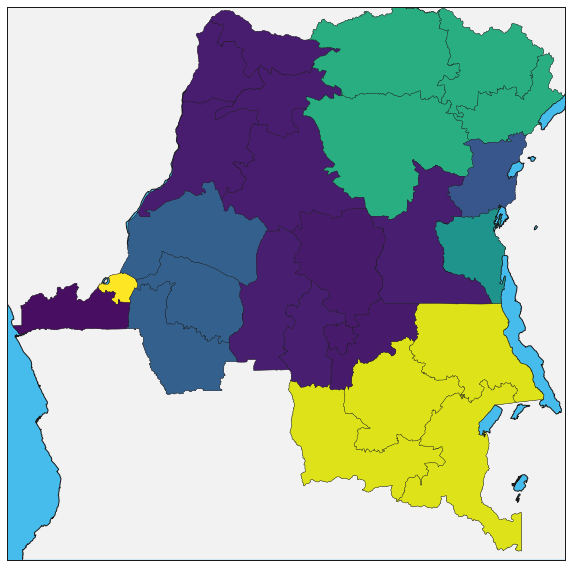

In [46]:
#Same map as before, but now color-coded by the risk calculated for case plus vacc
z = risk[:,1]
#z = gpdata[toplot].values
z[np.isinf(z)] = np.nan
clist = []
#Now you need to match this to the color
for n in df_poly.name:
    j = locs.index(n)
    clist.append(norm(z[j]))
fig, ax = plt.subplots(figsize=(10,20));
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.readshapefile('/Users/laurasampson/Work/shapefiles/DRC/GISunit/dps','areas') #DRC
pc = PatchCollection(df_poly.shapes, zorder=2)
pc.set_facecolor(cmap(clist))
ax.add_collection(pc)
plt.savefig("RiskMap_vaxcase.png",dpi=100,bbox_inches='tight')

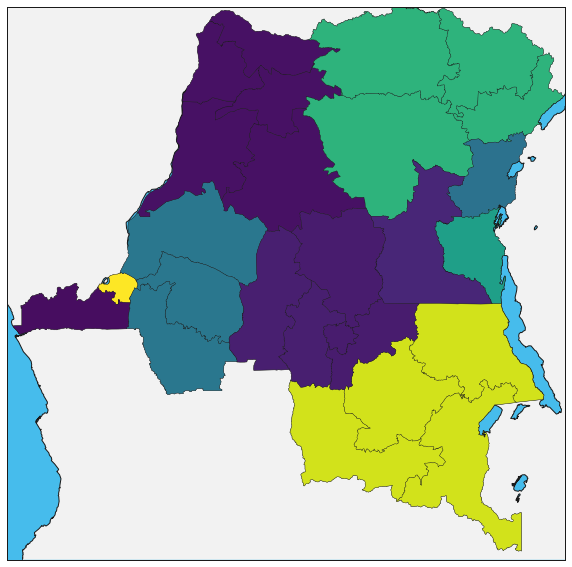

In [47]:
#Same map as before, but now color-coded by the risk calculated for all data
z = risk[:,2]
#z = gpdata[toplot].values
z[np.isinf(z)] = np.nan
clist = []
#Now you need to match this to the color
for n in df_poly.name:
    j = locs.index(n)
    clist.append(norm(z[j]))
fig, ax = plt.subplots(figsize=(10,20));
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.readshapefile('/Users/laurasampson/Work/shapefiles/DRC/GISunit/dps','areas') #DRC
pc = PatchCollection(df_poly.shapes, zorder=2)
pc.set_facecolor(cmap(clist))
ax.add_collection(pc)
plt.savefig("RiskMap_alldata.png",dpi=100,bbox_inches='tight')

BANDUNDU
EQUATEUR
KATANGA
KINSHASA
NKIVU
ORIENTALE
SKIVU


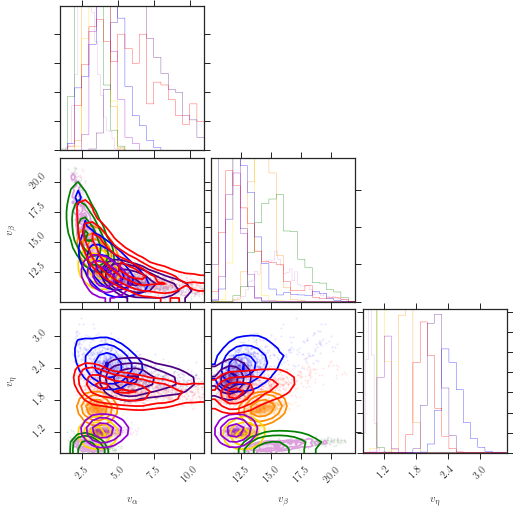

In [104]:
#2-d posteriors for a subset of the parameters (vacc. hazard)
burnin = 1000
loc_subset = ['BANDUNDU', 'EQUATEUR', 'KATANGA', 'KINSHASA', 'NKIVU', 'ORIENTALE',\
              'SKIVU']
color = ['darkorange', 'gold', 'green', 'blue', 'indigo', 'darkviolet', 'red', 'grey', 'plum', 'firebrick']

ranges = [(1.,11.),(10.,22.),(0.8,3.5)]
samples = []
i = 0
for line in open('chains/BFtest/KATANGA/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1
samples = np.array(samples)
samples = samples.astype(float)
csamp = samples[-1000:,0:3].copy()
fig = corner.corner(csamp,normed=True,color='plum',labels=[r"$v_\alpha$", r"$v_\beta$", r"$v_\eta$"],\
                    bins=50,range=ranges)

j = 0
for prov in loc_subset:
    print prov
    samples = []
    c = color[j]
    i = 0
    for line in open('chains/BFtest/'+prov+'/chain_1.txt','r'):
        sample = line.split()
        if i> burnin:
            samples.append(sample)
        i += 1
    samples = np.array(samples)
    samples = samples.astype(float)
    csamp = samples[-1000:,0:3].copy()
    #corner.corner(csamp,range=ranges,no_fill_contours=True,bins=50,plot_density=False,plot_countours=False,color=c,fig=fig)
    corner.corner(csamp,range=ranges,no_fill_contours=True,smooth=True,plot_density=False,plot_countours=False,color=c,fig=fig)
    j += 1
    
fig.savefig('cornerplotvparams.pdf')

BANDUNDU
EQUATEUR
KATANGA
KINSHASA
NKIVU
ORIENTALE
SKIVU


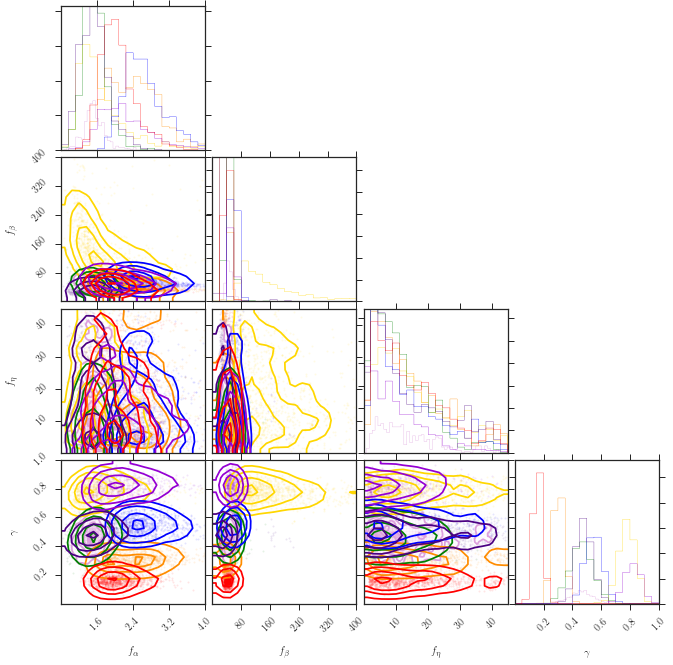

In [105]:
#Different subset (foi)
burnin = 1000
loc_subset = locs
loc_subset = ['BANDUNDU', 'EQUATEUR', 'KATANGA', 'KINSHASA', 'NKIVU', 'ORIENTALE',\
              'SKIVU']
color = ['darkorange', 'gold', 'green', 'blue', 'indigo', 'darkviolet', 'red', 'plum', 'firebrick']

ranges = [(0.8,4.),(0.,400.),(0.,45.),(0.,1.)]
samples = []
i = 0
for line in open('chains/BFtest/KATANGA/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1
samples = np.array(samples)
samples = samples.astype(float)
csamp = samples[-500:,3:7].copy()
fig = corner.corner(csamp,normed=True,color='plum',smooth=True,labels=[r"$f_\alpha$", r"$f_\beta$", r"$f_\eta$",r"$\gamma$"], \
                    bins=50,range=ranges)

j = 0
for prov in loc_subset:
    print prov
    samples = []
    c = color[j]
    i = 0
    for line in open('chains/BFtest/'+prov+'/chain_1.txt','r'):
        sample = line.split()
        if i> burnin:
            samples.append(sample)
        i += 1
    samples = np.array(samples)
    samples = samples.astype(float)
    csamp = samples[-1000:,3:7].copy()
    corner.corner(csamp,range=ranges,no_fill_contours=True,smooth=True,plot_density=False,plot_countours=False,color=c,fig=fig)
    j += 1

fig.savefig('cornerplotfparams.pdf')


BANDUNDU
EQUATEUR
KATANGA
KINSHASA
NKIVU
ORIENTALE
SKIVU


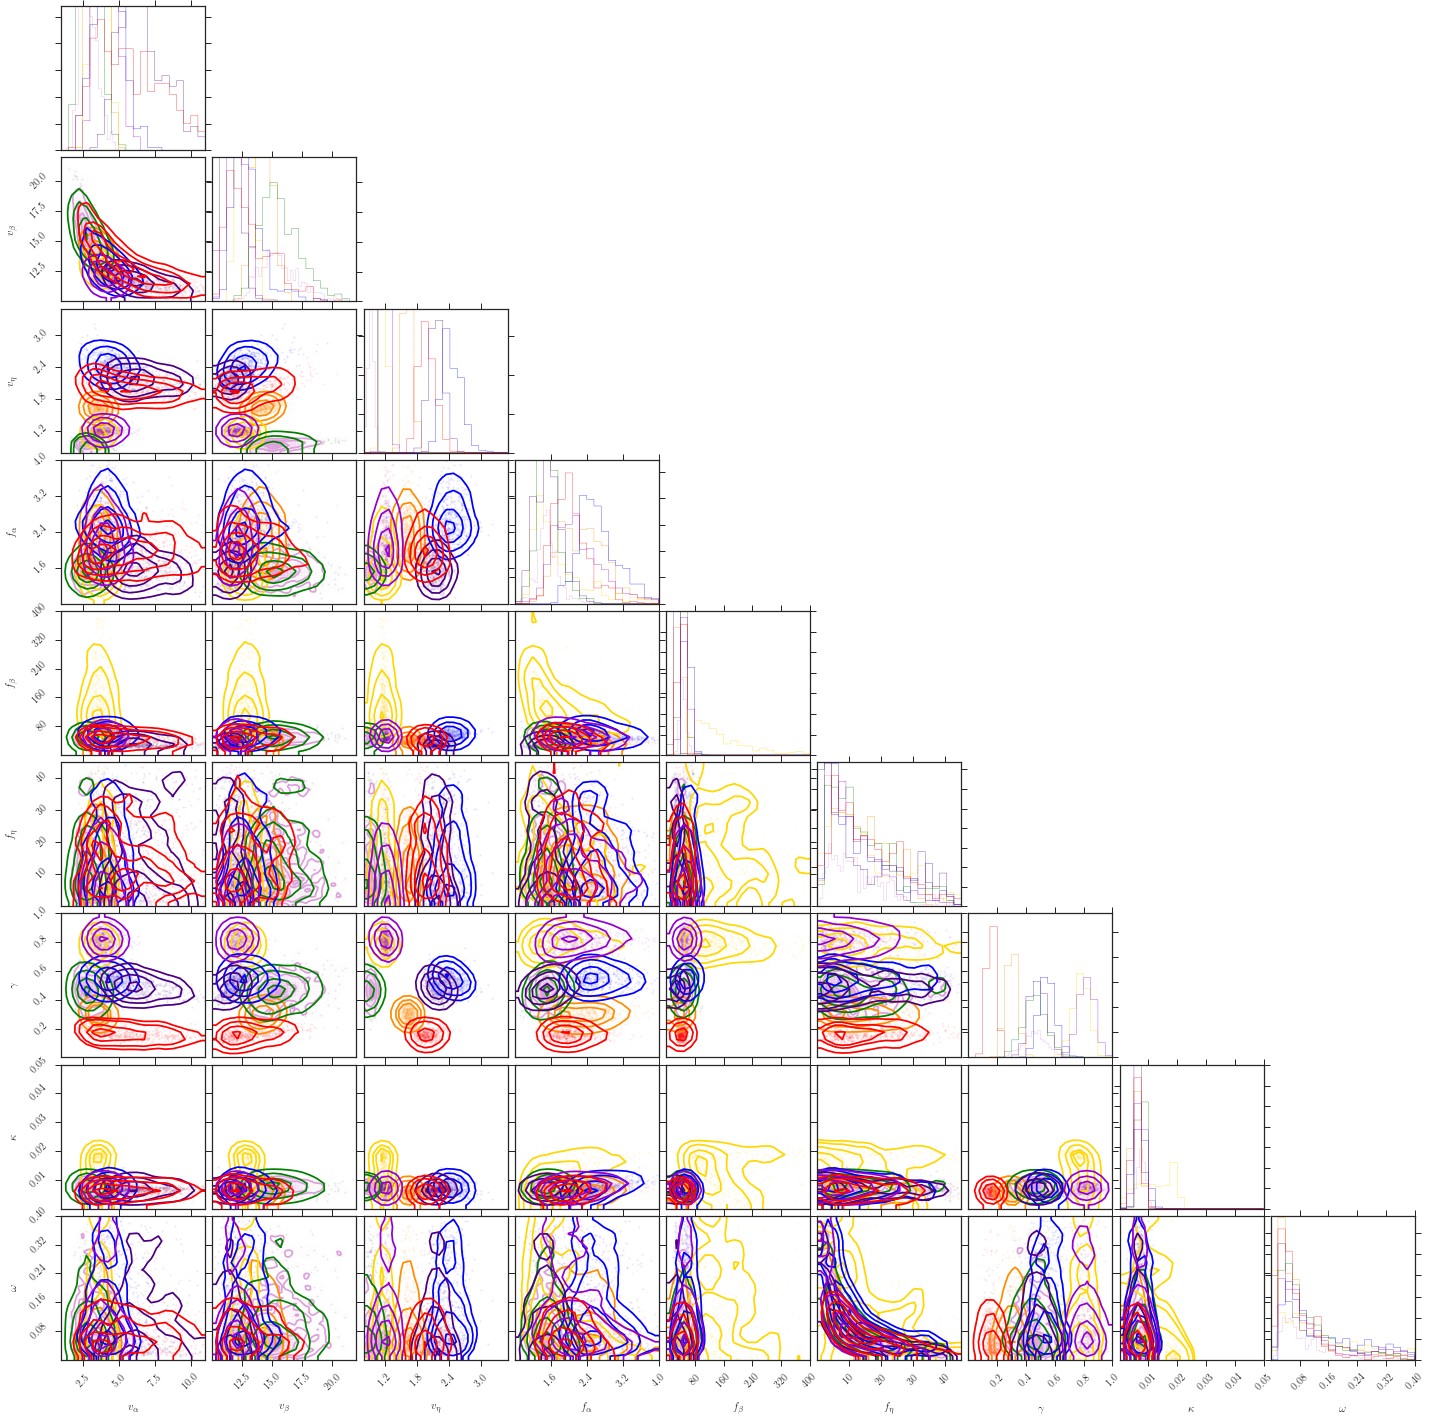

In [118]:
#What about the cross-parameters?
#Different subset (foi)
burnin = 1000
loc_subset = locs
loc_subset = ['BANDUNDU', 'EQUATEUR', 'KATANGA', 'KINSHASA', 'NKIVU', 'ORIENTALE',\
              'SKIVU']
color = ['darkorange', 'gold', 'green', 'blue', 'indigo', 'darkviolet', 'red', 'plum', 'firebrick']

ranges = [(1.,11.),(10.,22.),(0.8,3.5),(0.8,4.),(0.,400.),(0.,45.),(0.,1.),(0.,0.05),(0.,0.4)]
samples = []
i = 0
for line in open('chains/BFtest/KATANGA/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1
samples = np.array(samples)
samples = samples.astype(float)
csamp = samples[-500:,0:9].copy()
fig = corner.corner(csamp,normed=True,color='plum',smooth=True,labels=[r"$v_\alpha$", r"$v_\beta$", r"$v_\eta$",\
                                                                       r"$f_\alpha$", r"$f_\beta$", r"$f_\eta$",r"$\gamma$",\
                                                                      r"$\kappa$",r"$\omega$"], \
                    bins=50,range=ranges)

j = 0
for prov in loc_subset:
    print prov
    samples = []
    c = color[j]
    i = 0
    for line in open('chains/BFtest/'+prov+'/chain_1.txt','r'):
        sample = line.split()
        if i> burnin:
            samples.append(sample)
        i += 1
    samples = np.array(samples)
    samples = samples.astype(float)
    csamp = samples[-500:,0:9].copy()
    corner.corner(csamp,range=ranges,no_fill_contours=True,smooth=True,plot_density=False,plot_countours=False,color=c,fig=fig)
    j += 1

fig.savefig('cornerplot.png',dpi=200,bbox_inches='tight')
